In [1]:

import pandas as pd

folder_path = './archive'

Read All .csv Files

In [2]:
features_df = pd.read_csv(folder_path + '/features.csv')
stores_df = pd.read_csv(folder_path + '/stores.csv')
test_df = pd.read_csv(folder_path + '/test.csv')
train_df = pd.read_csv(folder_path + '/train.csv')

Display All Files

In [3]:
print("✅ features.csv:", features_df.shape)
display(features_df.head())
print("✅ stores.csv:", stores_df.shape)
display(stores_df.head())
print("✅ test.csv:", test_df.shape)
display(test_df.head())
print("✅ train.csv:", train_df.shape)
display(train_df.head())

✅ features.csv: (8190, 12)


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


✅ stores.csv: (45, 3)


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


✅ test.csv: (115064, 4)


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


✅ train.csv: (421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Merge and Prepare the Training Data

In [4]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
train_merged = pd.merge(train_df, features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
train_merged = pd.merge(train_merged, stores_df, on='Store', how='left')
train_merged.sort_values(by=['Store', 'Dept', 'Date'], inplace=True)
print("FINAL MERGED TRAINING DATA SHAPE:", train_merged.shape)
train_merged.head()

FINAL MERGED TRAINING DATA SHAPE: (421570, 16)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


Step 5: Create Time-Based Features

In [5]:
train_merged['Year'] = train_merged['Date'].dt.year
train_merged['Month'] = train_merged['Date'].dt.month
train_merged['Week'] = train_merged['Date'].dt.isocalendar().week
train_merged['Day'] = train_merged['Date'].dt.day
train_merged['Lag_1'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
train_merged['Rolling_Mean_4'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1).rolling(window=4).mean()
print("UPDATED TRAINING DATA WITH TIME FEATURES:")
train_merged[['Date', 'Weekly_Sales', 'Lag_1', 'Rolling_Mean_4', 'Year', 'Month', 'Week']].head(10)

UPDATED TRAINING DATA WITH TIME FEATURES:


,Date,Weekly_Sales,Lag_1,Rolling_Mean_4,Year,Month,Week
0,2010-02-05,24924.50,NaN,NaN,2010,2,5
1,2010-02-12,46039.49,24924.50,NaN,2010,2,6
2,2010-02-19,41595.55,46039.49,NaN,2010,2,7
3,2010-02-26,19403.54,41595.55,NaN,2010,2,8
4,2010-03-05,21827.90,19403.54,32990.7700,2010,3,9
5,2010-03-12,21043.39,21827.90,32216.6200,2010,3,10
6,2010-03-19,22136.64,21043.39,25967.5950,2010,3,11
7,2010-03-26,26229.21,22136.64,21102.8675,2010,3,12
8,2010-04-02,57258.43,26229.21,22809.2850,2010,4,13
9,2010-04-09,42960.91,57258.43,31666.9175,2010,4,14


Step 6: Handle Missing Values and Prepare for Modeling

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

train_ready = train_merged.dropna(subset=['Lag_1', 'Rolling_Mean_4'])
feature_cols = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                'Size', 'IsHoliday', 'Lag_1', 'Rolling_Mean_4', 'Year', 'Month', 'Week']
train_ready = train_ready.assign(IsHoliday=train_ready['IsHoliday'].astype(int))
X = train_ready[feature_cols]
y = train_ready['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [7]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (326748, 13)
y_train shape: (326748,)
X_test shape: (81688, 13)
y_test shape: (81688,)


Step 7: Train and Evaluate a Linear Regression Model

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Linear Regression Evaluation Results:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Linear Regression Evaluation Results:
RMSE: 5382.75
R² Score: 0.9203


Step 8: Plot Actual vs. Predicted Sales (First 100)

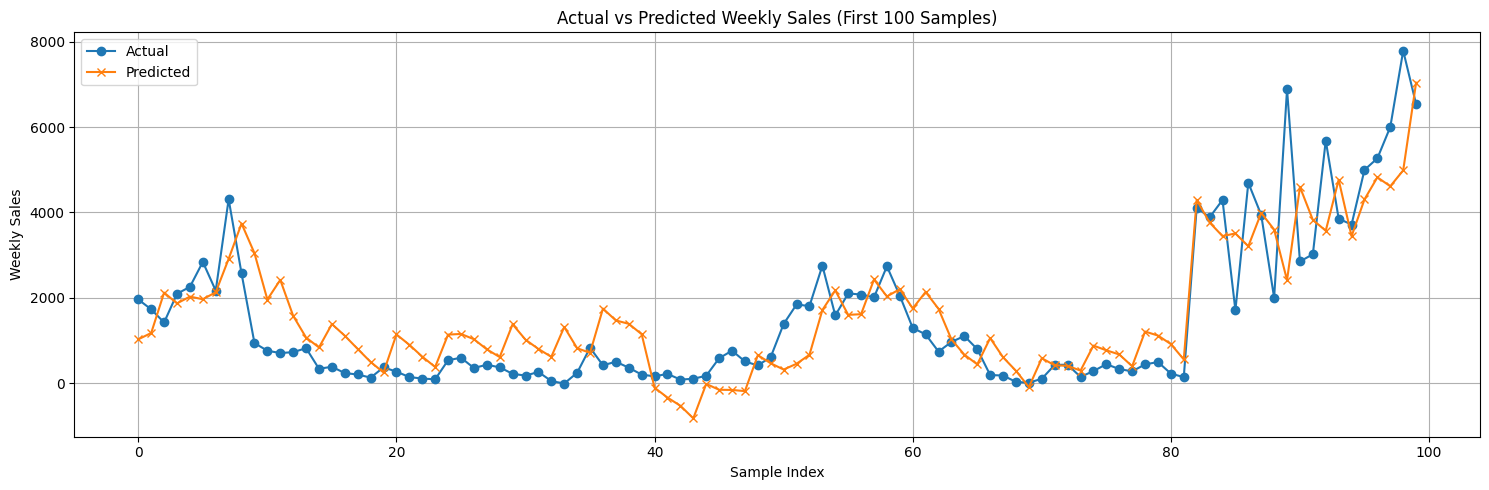

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title('Actual vs Predicted Weekly Sales (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
unique_stores = train_merged['Store'].nunique()
print(f"Number of unique stores: {unique_stores}")

unique_depts = train_merged['Dept'].nunique()
print(f"Number of unique departments: {unique_depts}")

unique_dates = train_merged['Date'].nunique()
print(f"Number of unique dates: {unique_dates}")

Number of unique stores: 45
Number of unique departments: 81
Number of unique dates: 143


In [13]:
train_merged['Date'] = pd.to_datetime(train_merged['Date'])
train_merged = train_merged.set_index('Date')
display(train_merged.head())

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,CPI,Unemployment,Type,Size,Year,Month,Week,Day,Lag_1,Rolling_Mean_4
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,...,211.096358,8.106,A,151315,2010,2,5,5,NaN,NaN
2010-02-12,1,1,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,...,211.242170,8.106,A,151315,2010,2,6,12,24924.50,NaN
2010-02-19,1,1,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,...,211.289143,8.106,A,151315,2010,2,7,19,46039.49,NaN
2010-02-26,1,1,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,...,211.319643,8.106,A,151315,2010,2,8,26,41595.55,NaN
2010-03-05,1,1,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,...,211.350143,8.106,A,151315,2010,3,9,5,19403.54,32990.77


In [15]:
# Merge dataframes to create df_merged_all
df_merged_all = pd.merge(train_df, features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
df_merged_all = pd.merge(df_merged_all, stores_df, on='Store', how='left')
df_merged_all['Date'] = pd.to_datetime(df_merged_all['Date'])
display(df_merged_all.head())

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [16]:
# Calculate outlier bounds using IQR for Weekly_Sales
Q1 = df_merged_all['Weekly_Sales'].quantile(0.25)
Q3 = df_merged_all['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

lower_bound_sales = Q1 - 1.5 * IQR
upper_bound_sales = Q3 + 1.5 * IQR

# Create df_outliers
df_outliers = df_merged_all[(df_merged_all['Weekly_Sales'] < lower_bound_sales) | (df_merged_all['Weekly_Sales'] > upper_bound_sales)].copy()

print(f"Lower bound for Weekly_Sales outliers: {lower_bound_sales:.2f}")
print(f"Upper bound for Weekly_Sales outliers: {upper_bound_sales:.2f}")
print(f"Number of outliers detected: {len(df_outliers)}")
display(df_outliers.head())

Lower bound for Weekly_Sales outliers: -25109.65
Upper bound for Weekly_Sales outliers: 47395.16
Number of outliers detected: 35521


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
8,1,1,2010-04-02,57258.43,False,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,A,151315
46,1,1,2010-12-24,55931.23,False,52.33,2.886,NaN,NaN,NaN,NaN,NaN,211.405122,7.838,A,151315
63,1,1,2011-04-22,50510.31,False,72.99,3.807,NaN,NaN,NaN,NaN,NaN,215.459905,7.682,A,151315
106,1,1,2012-02-17,54060.10,False,45.32,3.510,9873.33,11062.27,9.80,8409.31,3402.66,220.425759,7.348,A,151315
113,1,1,2012-04-06,57592.12,False,70.43,3.891,10121.97,NaN,77.98,3750.59,4510.72,221.435611,7.143,A,151315


In [18]:
# Encode IsHoliday and Type columns
df_merged_all['IsHoliday_encoded'] = df_merged_all['IsHoliday'].astype(int)
df_merged_all['Type_encoded'] = df_merged_all['Type'].astype('category').cat.codes

display(df_merged_all[['IsHoliday', 'IsHoliday_encoded', 'Type', 'Type_encoded']].head())

,IsHoliday,IsHoliday_encoded,Type,Type_encoded
0,False,0,A,0
1,True,1,A,0
2,False,0,A,0
3,False,0,A,0
4,False,0,A,0


In [19]:
total_weekly_sales = df_merged_all.groupby(df_merged_all.index)['Weekly_Sales'].sum()
display(total_weekly_sales.head())

,Weekly_Sales
0,24924.50
1,46039.49
2,41595.55
3,19403.54
4,21827.90


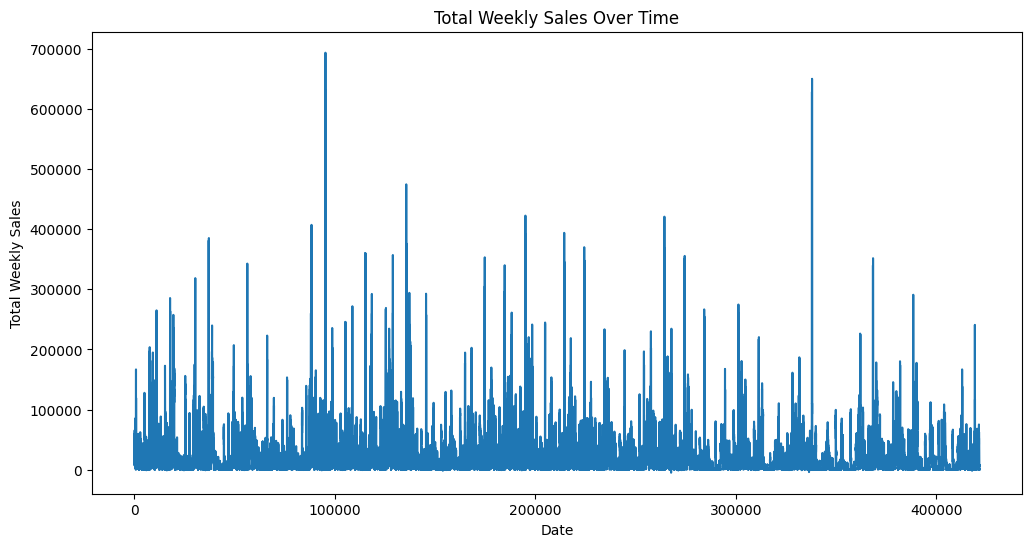

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(total_weekly_sales)
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.show()

Bonus Task 1: Rolling Averages + Seasonal Decomposition

In [21]:
train_merged['Rolling_Mean_8'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1).rolling(window=8).mean()
train_merged['Rolling_Mean_12'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1).rolling(window=12).mean()
train_ready = train_merged.dropna(subset=['Lag_1', 'Rolling_Mean_4', 'Rolling_Mean_8', 'Rolling_Mean_12']).copy()
train_ready['IsHoliday'] = train_ready['IsHoliday'].astype(int)

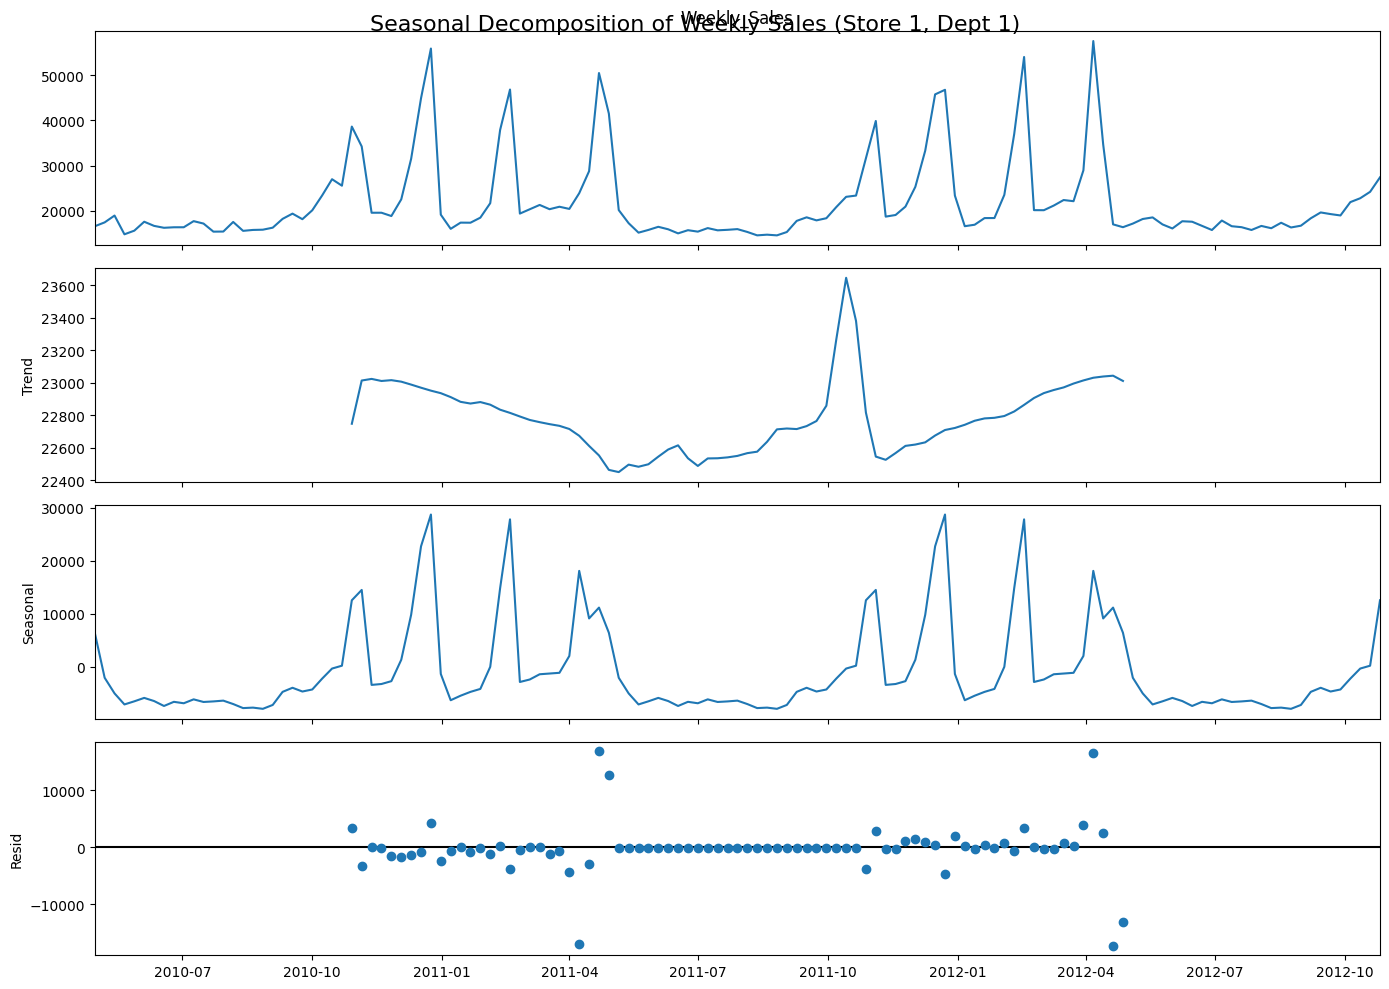

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

store_dept_data = train_ready[(train_ready['Store'] == 1) & (train_ready['Dept'] == 1)]
store_dept_data = store_dept_data.reset_index() # Reset index to make 'Date' a column
store_dept_data = store_dept_data.sort_values('Date')
ts = store_dept_data.set_index('Date')['Weekly_Sales']
decomposition = seasonal_decompose(ts, model='additive', period=52)
plt.rcParams.update({'figure.figsize': (14, 10)})
decomposition.plot()
plt.suptitle("Seasonal Decomposition of Weekly Sales (Store 1, Dept 1)", fontsize=16)
plt.show()

Bonus Task 2: Forecasting with XGBoost & Time-Aware Validation

In [24]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

feature_cols = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                'Size', 'IsHoliday', 'Lag_1', 'Rolling_Mean_4', 'Rolling_Mean_8', 'Rolling_Mean_12',
                'Year', 'Month', 'Week']
X = train_ready[feature_cols]
y = train_ready['Weekly_Sales']
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [25]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

feature_cols = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                'Size', 'IsHoliday', 'Lag_1', 'Rolling_Mean_4', 'Rolling_Mean_8', 'Rolling_Mean_12',
                'Year', 'Month', 'Week']
X = train_ready[feature_cols]
y = train_ready['Weekly_Sales']
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [26]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost Evaluation Results:")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.4f}")

XGBoost Evaluation Results:
RMSE: 3657.95
R² Score: 0.9636


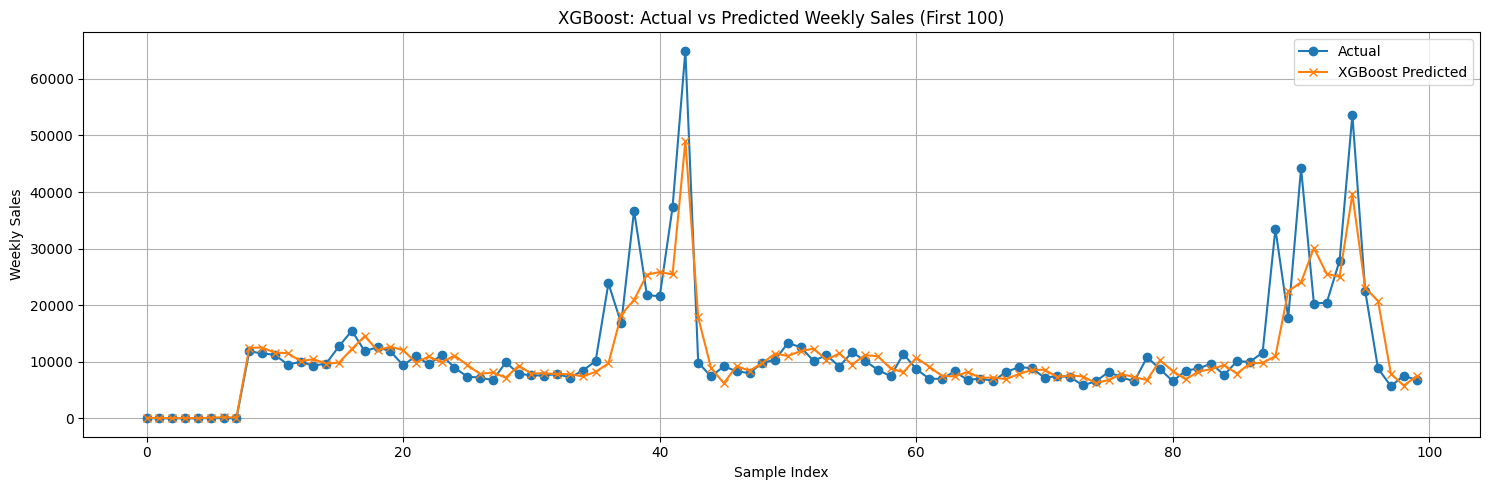

In [27]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred_xgb[:100], label='XGBoost Predicted', marker='x')
plt.title('XGBoost: Actual vs Predicted Weekly Sales (First 100)')
plt.xlabel('Sample Index')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

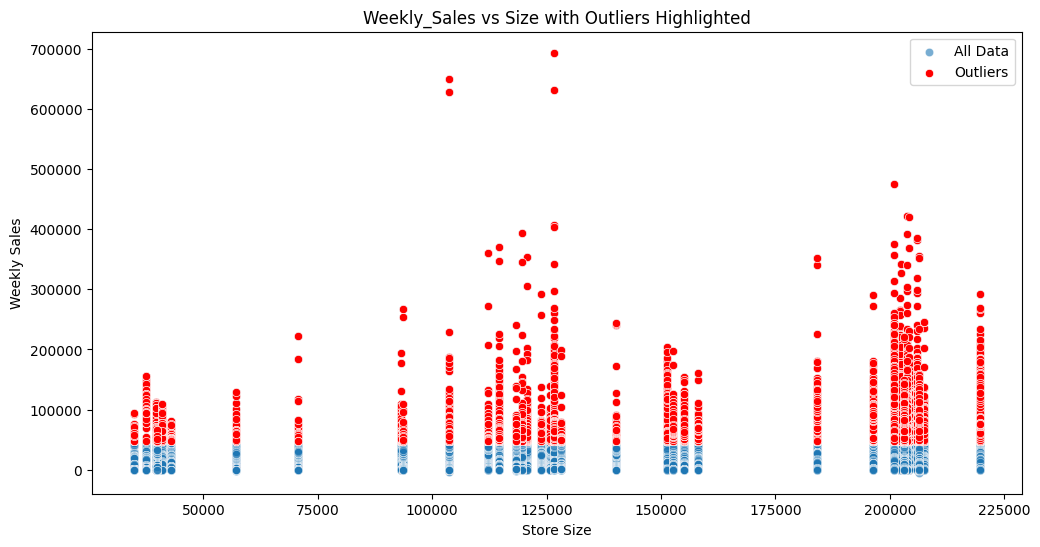

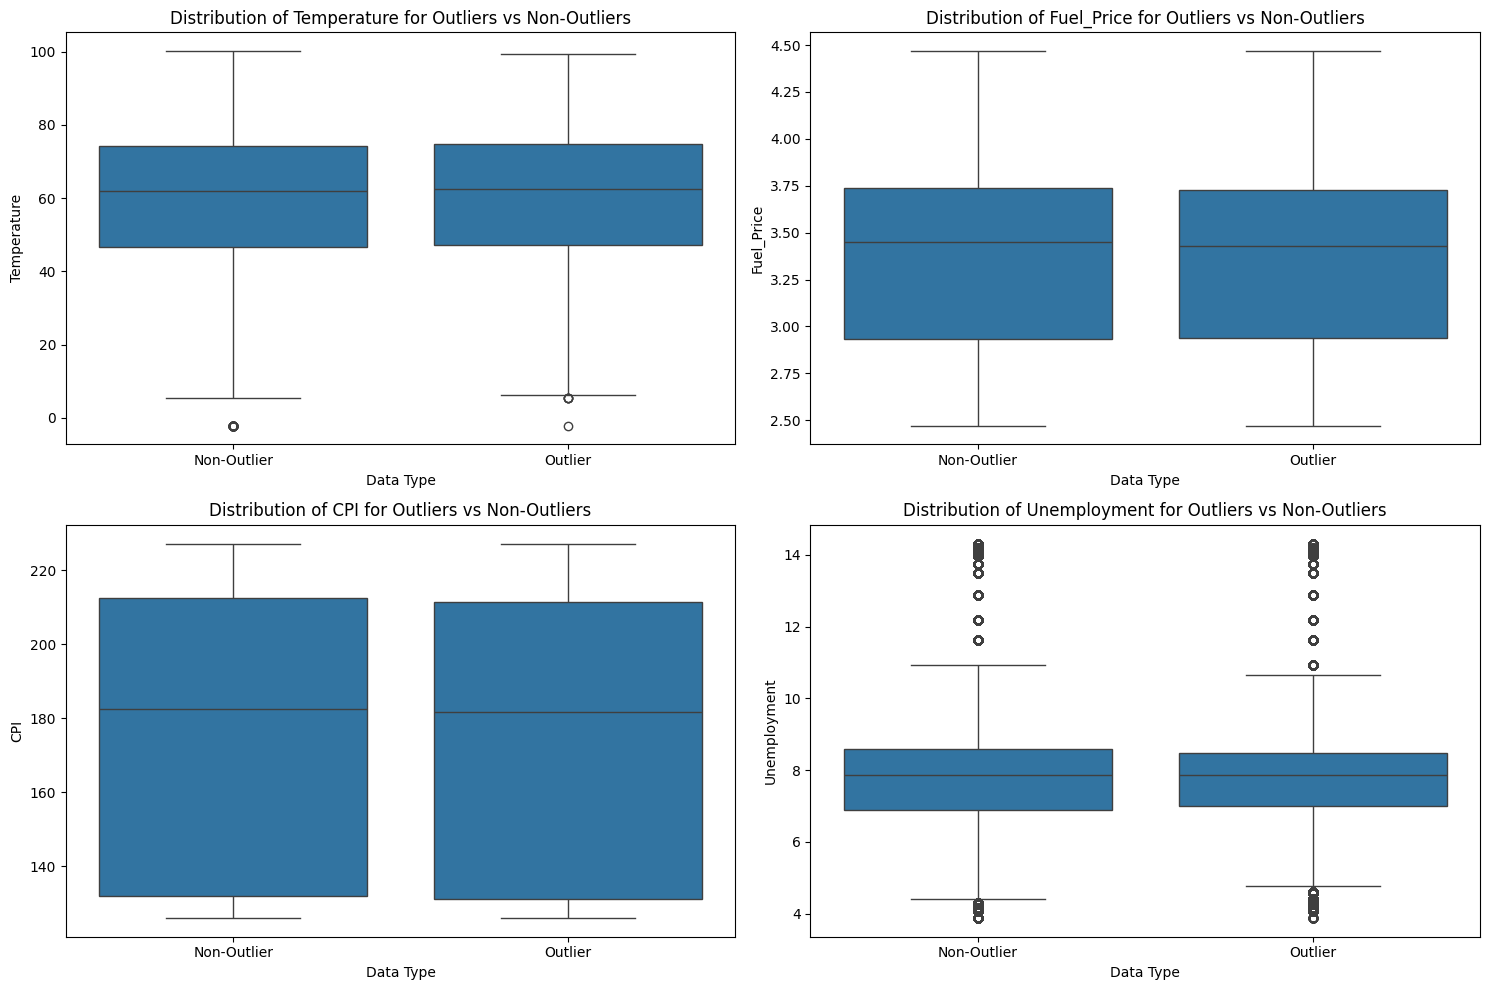

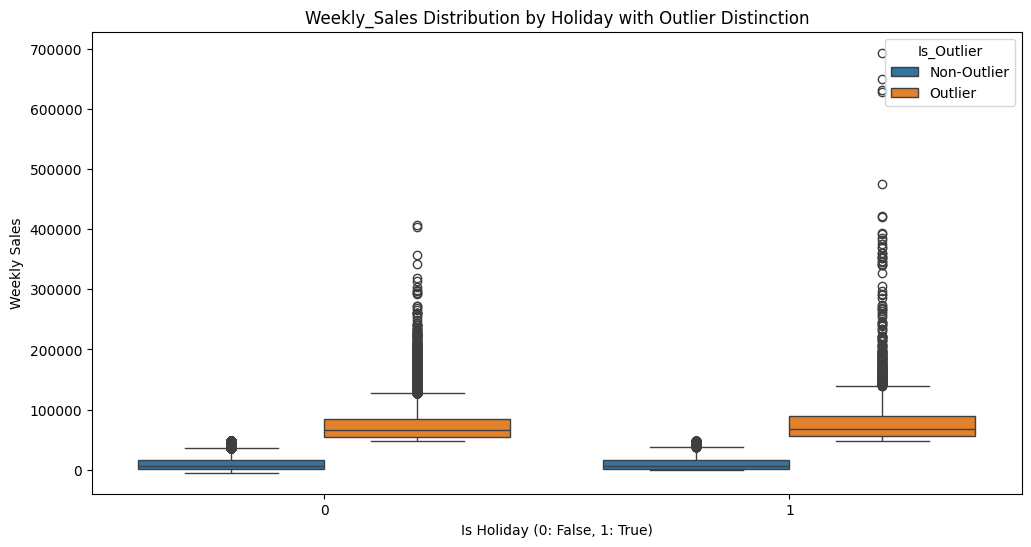

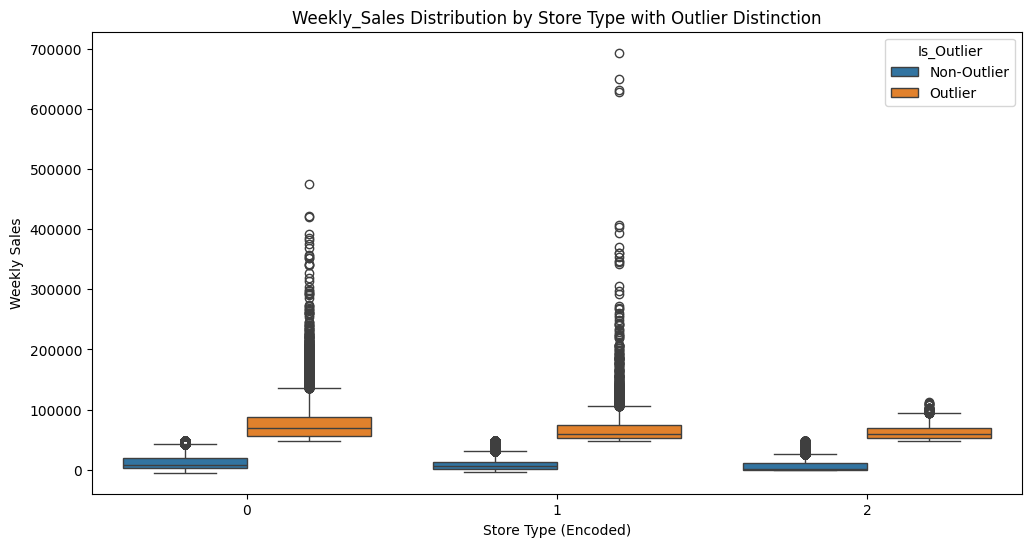

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Scatter plot of Weekly_Sales vs Size with outliers highlighted
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_merged_all, x='Size', y='Weekly_Sales', label='All Data', alpha=0.6)
sns.scatterplot(data=df_outliers, x='Size', y='Weekly_Sales', color='red', label='Outliers')
plt.title('Weekly_Sales vs Size with Outliers Highlighted')
plt.xlabel('Store Size')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

# 2. Box plots comparing distributions for outlier vs non-outlier data points
numerical_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
df_merged_all['Is_Outlier'] = df_merged_all['Weekly_Sales'].apply(lambda x: 'Outlier' if x < lower_bound_sales or x > upper_bound_sales else 'Non-Outlier')

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df_merged_all, x='Is_Outlier', y=col)
    plt.title(f'Distribution of {col} for Outliers vs Non-Outliers')
    plt.xlabel('Data Type')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

# 3. Box plots comparing Weekly_Sales distribution for holiday/non-holiday, distinguishing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_merged_all, x='IsHoliday_encoded', y='Weekly_Sales', hue='Is_Outlier')
plt.title('Weekly_Sales Distribution by Holiday with Outlier Distinction')
plt.xlabel('Is Holiday (0: False, 1: True)')
plt.ylabel('Weekly Sales')
plt.show()

# 4. Box plots comparing Weekly_Sales distribution across store types, distinguishing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_merged_all, x='Type_encoded', y='Weekly_Sales', hue='Is_Outlier')
plt.title('Weekly_Sales Distribution by Store Type with Outlier Distinction')
plt.xlabel('Store Type (Encoded)')
plt.ylabel('Weekly Sales')
plt.show()